<a href="https://colab.research.google.com/github/pseudo-xy/pseudo-xy/blob/main/california_housing_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32'

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [4]:
# Calculating the Z-scores of each column in the training set and
# writing those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examining some of the values of the normalized training set.
train_df_norm.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2045,1.1,-1.2,-1.1,4.9,4.0,3.5,4.1,0.8,0.5
16841,-1.9,1.8,1.4,-0.4,-0.4,-0.5,-0.4,-0.5,-1.1
13434,-1.2,1.3,-0.8,0.2,0.0,0.2,0.1,0.7,0.2
6954,0.6,-0.7,0.0,-0.3,0.1,0.6,0.2,-1.0,0.1
10397,-0.3,1.7,-1.6,-0.4,-0.6,-1.1,-1.1,0.4,-0.1


In [6]:
# Calculating the Z-scores of each column in the test set and
# writing those Z-scores into a new pandas DataFrame named test_df_norm. 
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

# setting the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)

2045    0.0
16841   0.0
13434   0.0
6954    0.0
10397   0.0
         ..
4327    0.0
2071    0.0
5914    1.0
12921   0.0
7247    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [7]:
# Creating an empty list that will eventually hold all created feature columns.
feature_columns = []

# Creating a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Creating a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Converting the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 0.8420808 ,  4.8631163 ],
       [-0.50586945, -0.41086522],
       [ 0.66547054,  0.16850665],
       ...,
       [-0.38984123, -0.3351753 ],
       [-0.11585952,  1.2997267 ],
       [-0.29383233, -0.28976136]], dtype=float32)>

In [9]:
 # Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  model = tf.keras.models.Sequential()

  # Adding the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Calling the compile method to construct the layers into a model that
  # TensorFlow can execute.   
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolating the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist   

In [10]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

Epoch 1/20


170/170 [==============================] - 1s 2ms/step - loss: 0.6337 - accuracy: 0.3695
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.5113
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5020 - accuracy: 0.6362
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.7073
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4341 - accuracy: 0.7481
Epoch 6/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4175 - accuracy: 0.7711
Epoch 7/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4077 - accuracy: 0.7857
Epoch 8/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4022 - accuracy: 0.7958
Epoch 9/20
170/170 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.8025
Epoch 10/20
170/170 [==============================] - 1s 3ms/step - loss: 0.3978 - accuracy: 0.8057
Epoch 11/2

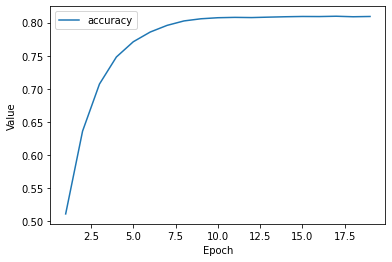

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establishing the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establishing the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Training the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [12]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 2ms/step - loss: 0.4069 - accuracy: 0.8007


[0.4068787395954132, 0.8006666898727417]

Epoch 1/20


170/170 [==============================] - 1s 3ms/step - loss: 0.5276 - accuracy: 0.6034 - precision: 0.3765 - recall: 0.8959
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4933 - accuracy: 0.6507 - precision: 0.4061 - recall: 0.8613
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4662 - accuracy: 0.6866 - precision: 0.4333 - recall: 0.8253
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4443 - accuracy: 0.7202 - precision: 0.4647 - recall: 0.7911
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.7442 - precision: 0.4921 - recall: 0.7514
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4144 - accuracy: 0.7666 - precision: 0.5241 - recall: 0.7130
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4061 - accuracy: 0.7821 - precision: 0.5515 - recall: 0.6828
Epoch 8/20
170/170 [==============================] 

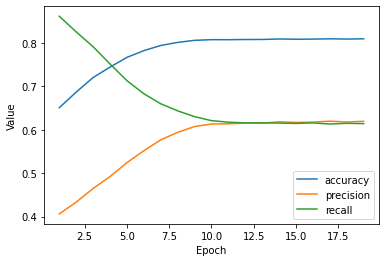

In [13]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# showing the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establishing the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

Epoch 1/20


170/170 [==============================] - 1s 2ms/step - loss: 1.1116 - accuracy: 0.3148 - precision: 0.0827 - recall: 0.1726
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.9931 - accuracy: 0.3768 - precision: 0.0705 - recall: 0.1227
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.8911 - accuracy: 0.4768 - precision: 0.0578 - recall: 0.0716
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.8043 - accuracy: 0.6275 - precision: 0.0694 - recall: 0.0396
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7317 - accuracy: 0.7216 - precision: 0.1296 - recall: 0.0200
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6699 - accuracy: 0.7380 - precision: 0.1854 - recall: 0.0144
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6185 - accuracy: 0.7439 - precision: 0.2569 - recall: 0.0132
Epoch 8/20
170/170 [==============================] 

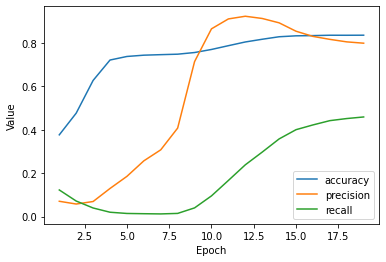

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# showing the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establishing the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

Epoch 1/20


170/170 [==============================] - 1s 2ms/step - loss: 0.7848 - auc: 0.5499
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6835 - auc: 0.6249
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5995 - auc: 0.6886
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5338 - auc: 0.7388
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4842 - auc: 0.7758
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4480 - auc: 0.8022
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4244 - auc: 0.8192
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4101 - auc: 0.8297
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4021 - auc: 0.8352
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3988 - auc: 0.8364
Epoch 11/20
170/170 [==============================] - 0s 2m

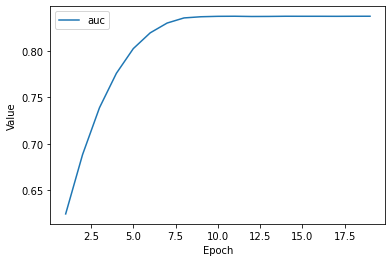

In [15]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establishing the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)